# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project code solution (Dick Carrillo)
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

The solution is based on each rubric requirements.

---


## Loading libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
#import numpy as np
#import cv2
#import glob
import time
from sklearn.svm import LinearSVC
#from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
from own_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Loading training data provided by Udacity

In [2]:
car_images = glob.glob('training_data/vehicles/**/*.png')
noncar_images = glob.glob('training_data/non-vehicles/**/*.png')
print(len(noncar_images), len(car_images))


8968 8792


# Visualizing some training data
Here I used similar code used in the previous project (chessboard corners)

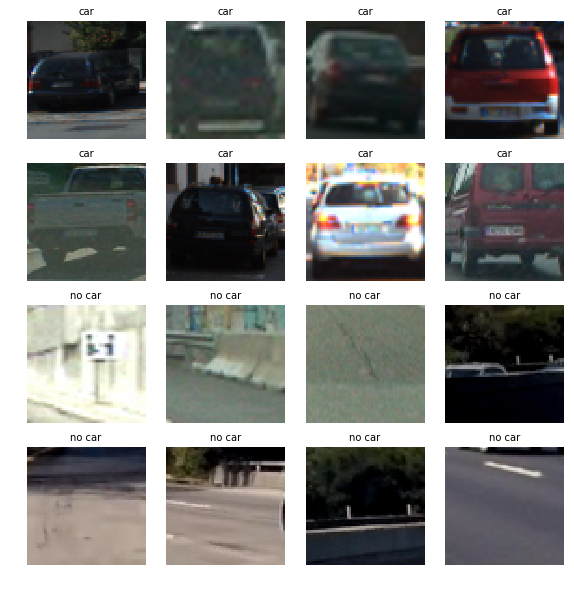

In [3]:
fig, axs = plt.subplots(4,4, figsize=(10, 10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list
for i in np.arange(8):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('no car', fontsize=10)
    axs[i].imshow(img)

# Histogram of Oriented Gradients (HOG)

## Defining functions used to extract HOG features
The source of this course was taken from Term_1/Lesson 20/Section 29.

In [4]:
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
import time

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_featuress(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


### visualizing some HOG image maps of Car and non car images.

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


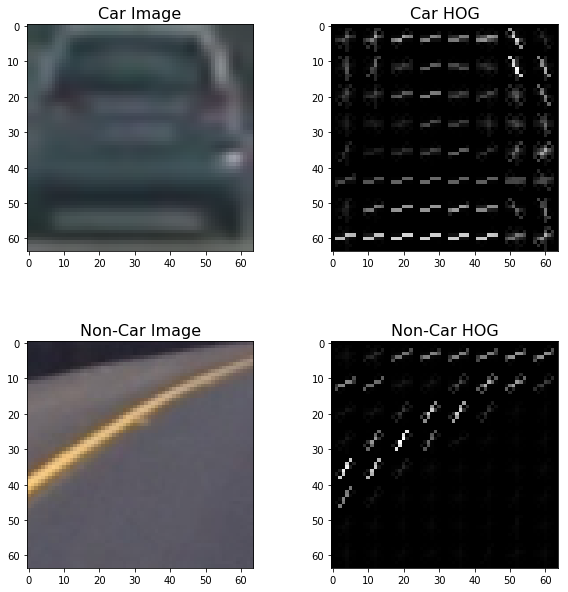

In [5]:
# Reading any image of car group
image_car = mpimg.imread(car_images[10])
# using get_hog_features() function provided by Udacity in classroom.
_, car_hog_image = get_hog_features(image_car[:,:,0], 9, 8, 8, vis=True, feature_vec=False )

# Reading any image of non car group
image_non_car = mpimg.imread(noncar_images[10])
# using get_hog_features() function provided by Udacity in classroom.
_, noncar_hog_image = get_hog_features(image_non_car[:,:,0], 9, 8, 8, vis=True, feature_vec=False)

# Visualization of original images and HUG maps.
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(image_car)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_hog_image, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(image_non_car)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_hog_image, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

### Extracting features of HOG maps
In this stage, I used also Udacity code provided in code. However parameter selection was done using a custome function called `tweak_function_hug_extracting_features()`. 

Extracting features using HOG is done using different color spaces, with specific orientation vectors number for each cell (with its pix_per_cell value), it is also considered a normalization in every block of subset image.

In [6]:
if False:
# Reduce the sample size because HOG features are slow to compute
    # The quiz evaluator times out after 13s of CPU time
    sample_size = 500
    cars = car_images[0:sample_size]
    notcars = noncar_images[0:sample_size]

        ### TODO: Tweak these parameters and see how the results change.
    def tweak_function_hug_extracting_features(cars, notcars, colorspace= 'HLS', orient=9, pix_per_cell = 8, cell_per_block=2, hog_channel="ALL"):
        t=time.time()
        #colorspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        #orient = 9
        #pix_per_cell = 8
        #cell_per_block = 2
        #hog_channel = 1 # Can be 0, 1, 2, or "ALL"
        car_features = extract_featuress(cars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
        notcar_features = extract_featuress(notcars, cspace=colorspace, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract HOG features...')

        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)

        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=rand_state)

        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X_train)
        # Apply the scaler to X
        X_train = X_scaler.transform(X_train)
        X_test = X_scaler.transform(X_test)

        #print('Using:',orient,'orientations',pix_per_cell,
        #    'pixels per cell and', cell_per_block,'cells per block')
        print('Feature vector length:', len(X_train[0]))
        # Use a linear SVC 
        svc = LinearSVC()
        # Check the training time for the SVC
        t=time.time()
        svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
        return round(svc.score(X_test, y_test), 4)
        # Check the prediction time for a single sample
        #t=time.time()
        #n_predict = 10
        #print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
        #print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        #t2 = time.time()
        #print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

    # Running the feature extracting function for different values of orient and colorspaces
    # Using: 8 pixels per cell and 2 cells per block in all cases
    colorspace_options = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
    accuracy_best = 0
    for colorspace in colorspace_options:
        for orient in range(9,13):
            print('--------------------------------------------------')
            print('Color Space tested = ',colorspace)
            print('Number of orientations of HOG  = ',orient)
            accuracy_value = tweak_function_hug_extracting_features(cars, notcars, colorspace= 'HLS', orient=9, pix_per_cell = 8, cell_per_block=2, hog_channel="ALL")
            print('***************************************************')
            print('')
            if accuracy_value > accuracy_best:
                accuracy_best = accuracy_value
                color_space_best = colorspace
                orient_best = orient

    print('The best configuration of parameters was:')
    print('Color Space = ',color_space_best,'  HOG orientation = ', orient_best, '  with Accuracy = ', accuracy_best)

### Best HOG configuration parameters 
The best configuration of parameters was:
`Color Space =  HLS   HOG orientation =  10   with Accuracy =  0.98. Using: 8 pixels per cell and 2 cells per block in all cases`

# Trainning the classifier with dataset of cars and non cars groups


### Extracting features of dataset (cars and non cars)
In this case we considered hog features, historgram features, and spatial features.
The parameters are described in following lines

In [7]:
# Adding Emergency
color_space = 'YCrCb' #'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
# Bin spatial parameters
spatial_size = (16, 16) # Spatial binning dimensions
# Histogram parameters
hist_bins = 32    # Number of histogram bins
hist_range = (0, 256)
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 700] # Min and max in y to search in slide_window()

car_features = extract_features(car_images)
notcar_features = extract_features(noncar_images)


C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Training classifier 
I used a randomized training and test sets

In [8]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5568
41.48 Seconds to train SVC...
Test Accuracy of SVC =  0.9938


# Slide Window

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


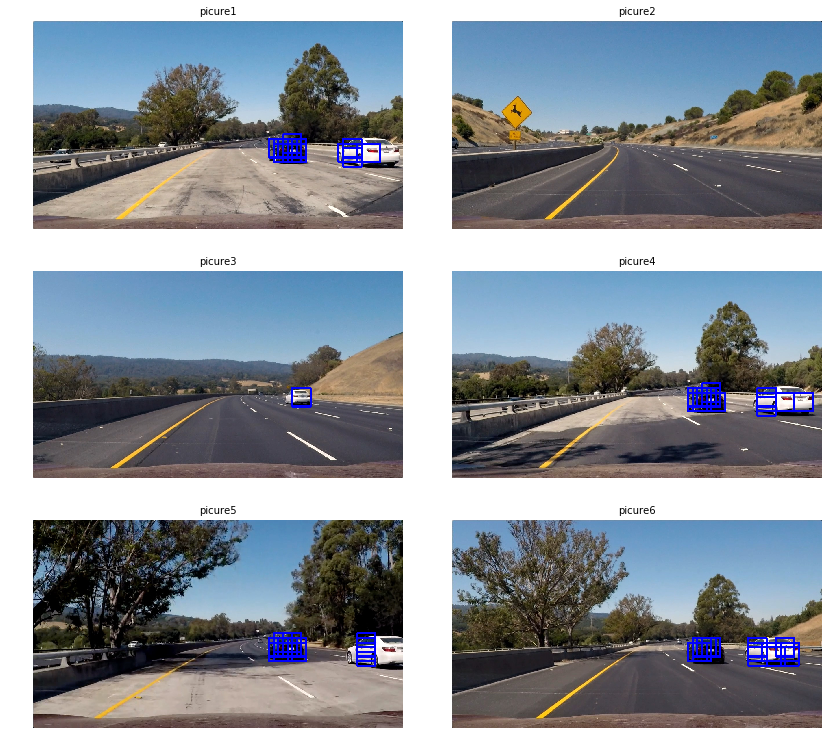

In [9]:
def getting_windows_info(path):
    #image = cv2.imread('./video_lab/bbox-example-image.jpg')
    #image = cv2.imread('./video_lab/frame1.jpg')
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = mpimg.imread('./video_lab/frame22.jpg')
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(64, 64), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    return window_img
    #plt.imshow(window_img)


fig, axs = plt.subplots(3,2, figsize=(15, 13))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

path_test_images = glob.glob('./test_images/*.jpg')
i = 0
for path in path_test_images:
    window_img = getting_windows_info(path)
    axs[i].axis('off')
    axs[i].set_title('picure'+str(i+1), fontsize=10)
    axs[i].imshow(window_img)
    i+=1
    


    



C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


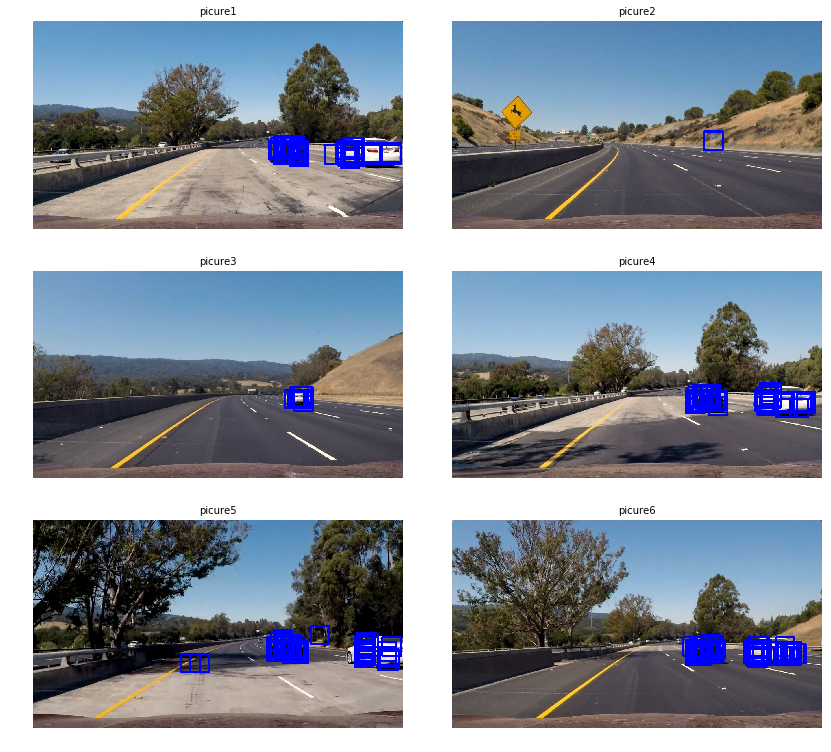

In [10]:
ystart = 350
ystop = 700
scale = 1

fig, axs = plt.subplots(3,2, figsize=(15, 13))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

path_test_images = glob.glob('./test_images/*.jpg')
i = 0
for path in path_test_images:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    box_list,window_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    axs[i].axis('off')
    axs[i].set_title('picure'+str(i+1), fontsize=10)
    axs[i].imshow(window_img)
    i+=1

### Multiple Detection and False Positives

C:\ProgramData\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


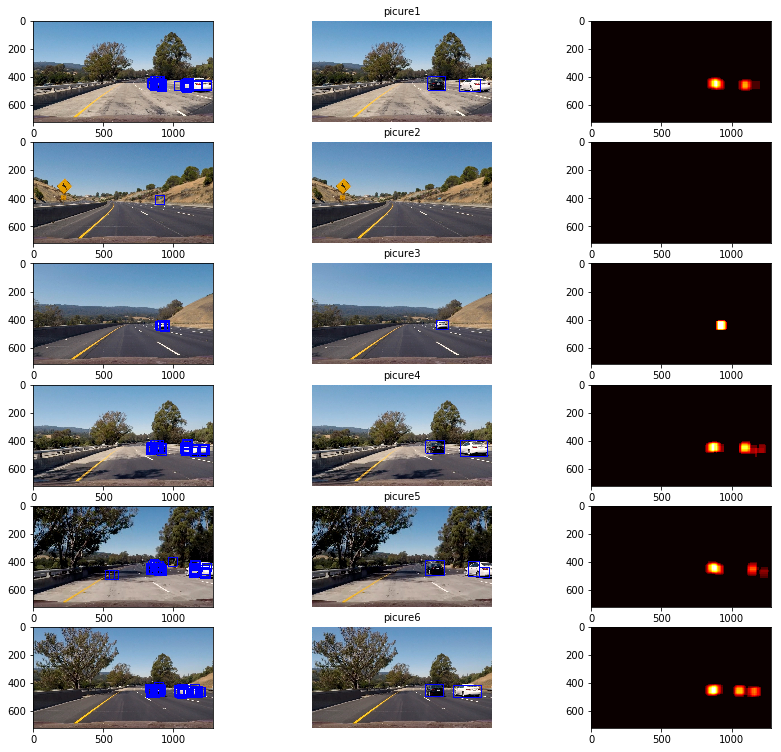

In [11]:
# Read in image similar to one shown above 
image = cv2.imread('./video_lab/frame1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

if False:
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

#fig = plt.figure()
#plt.subplot(121)
#plt.imshow(draw_img)
#plt.title('Car Positions')
#plt.subplot(122)
#plt.imshow(heatmap, cmap='hot')
#plt.title('Heat Map')
#fig.tight_layout()

fig, axs = plt.subplots(6,3, figsize=(15, 13))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

path_test_images = glob.glob('./test_images/*.jpg')
i = 0
for path in path_test_images:
    #box_listt = []
    
    #print(len(box_listt))
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    box_listt,window_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    #print('Iteracao'+str(i),len(box_listt))
    
    # Add heat to each box in box list
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat,box_listt)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)
    #print(heat)
    #print(type(heat))
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    axs[i*3].imshow(window_img)
    
    axs[i*3+1].axis('off')
    axs[i*3+1].set_title('picure'+str(i+1), fontsize=10)
    axs[i*3+1].imshow(draw_img)
    
    axs[i*3+2].imshow(heatmap, cmap='hot')
    
    i+=1


# Video Pipeline

In [12]:
class parametros_video():
    def __init__(self):
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale
        self.svc = svc
        self.X_scaler = X_scaler
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins

In [13]:
from moviepy.editor import VideoFileClip
from functools import reduce

class HeatHistory():
    def __init__(self):
        self.history = []

def processVideo(inputVideo, outputVideo, frames_to_remember=3, threshhold=1):
    """
    Process the video `inputVideo` to find the cars and saves the video to `outputVideo`.
    """
    history = HeatHistory()

    def pipeline(img):
        #return(img)
        if True:
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            parametros = parametros_video()
            ystart = parametros.ystart
            ystop = parametros.ystop 
            scale = parametros.scale 
            svc = parametros.svc
            X_scaler = parametros.X_scaler 
            orient = parametros.orient
            pix_per_cell = parametros.pix_per_cell
            cell_per_block = parametros.cell_per_block 
            spatial_size = parametros.spatial_size
            hist_bins = parametros.hist_bins
            
            box_listt,window_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

            print('dick')

            heat = np.zeros_like(img[:,:,0]).astype(np.float)
            heat = add_heat(heat,box_listt)
    
            # Apply threshold to help remove false positives
            heat = apply_threshold(heat,2)
            #heatmap = apply_threshold(heat_history, 2)
            labels = label(heat)

            return draw_labeled_bboxes(np.copy(img), labels)

    myclip = VideoFileClip(inputVideo)
    output_video = myclip.fl_image(pipeline).subclip(1,2)
    output_video.write_videofile(outputVideo, audio=False)
    
processVideo('test_video.mp4', './video_output/project_video_teste.mp4', threshhold=2)

dick
dick
[MoviePy] >>>> Building video ./video_output/project_video_teste.mp4
[MoviePy] Writing video ./video_output/project_video_teste.mp4


  0%|                                                   | 0/26 [00:00<?, ?it/s]

dick


  4%|█▋                                         | 1/26 [00:08<03:34,  8.57s/it]

dick


  8%|███▎                                       | 2/26 [00:16<03:23,  8.46s/it]

dick


 12%|████▉                                      | 3/26 [00:25<03:12,  8.39s/it]

dick


 15%|██████▌                                    | 4/26 [00:33<03:04,  8.38s/it]

dick


 19%|████████▎                                  | 5/26 [00:41<02:54,  8.32s/it]

dick


 23%|█████████▉                                 | 6/26 [00:50<02:49,  8.49s/it]

dick


 27%|███████████▌                               | 7/26 [00:58<02:39,  8.40s/it]

dick


 31%|█████████████▏                             | 8/26 [01:06<02:29,  8.30s/it]

dick


 35%|██████████████▉                            | 9/26 [01:15<02:21,  8.35s/it]

dick


 38%|████████████████▏                         | 10/26 [01:23<02:13,  8.33s/it]

dick


 42%|█████████████████▊                        | 11/26 [01:32<02:06,  8.43s/it]

dick


 46%|███████████████████▍                      | 12/26 [01:40<01:57,  8.39s/it]

dick


 50%|█████████████████████                     | 13/26 [01:48<01:49,  8.40s/it]

dick


 54%|██████████████████████▌                   | 14/26 [01:57<01:40,  8.41s/it]

dick


 58%|████████████████████████▏                 | 15/26 [02:05<01:31,  8.35s/it]

dick


 62%|█████████████████████████▊                | 16/26 [02:14<01:24,  8.43s/it]

dick


 65%|███████████████████████████▍              | 17/26 [02:22<01:15,  8.38s/it]

dick


 69%|█████████████████████████████             | 18/26 [02:30<01:06,  8.27s/it]

dick


 73%|██████████████████████████████▋           | 19/26 [02:38<00:57,  8.21s/it]

dick


 77%|████████████████████████████████▎         | 20/26 [02:46<00:49,  8.21s/it]

dick


 81%|█████████████████████████████████▉        | 21/26 [02:54<00:40,  8.15s/it]

dick


 85%|███████████████████████████████████▌      | 22/26 [03:02<00:32,  8.04s/it]

dick


 88%|█████████████████████████████████████▏    | 23/26 [03:10<00:23,  7.97s/it]

dick


 92%|██████████████████████████████████████▊   | 24/26 [03:19<00:16,  8.40s/it]

dick


 96%|████████████████████████████████████████▍ | 25/26 [03:26<00:07,  7.98s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./video_output/project_video_teste.mp4 

